In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
import yaml, matplotlib, random, pickle, time
import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import morlet2, cwt
from sklearn.mixture import GaussianMixture

from helper import _rotational, angle_calc

# Start Analysis

In [3]:
with open("config.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [112]:
# Initialize
files_ref, bad_frames_ref = {}, {}
frame_start = 0
bp_list, scale_list, angles_list, power_list = [], [], [], []

# Bodypoints Used for Analysis
bp_analyze = []
for angle_points in config["angles"]:
    bp_analyze.extend(angle_points.values())
bp_analyze.append(config["bp_rotate"])
bp_analyze.extend(config["bp_scale"])
bp_analyze.append(config["bp_center"])
bp_analyze = np.unique(bp_analyze)

for path in tqdm(glob(f"{config['input_data_path']}/**/*.h5")):
    # Import
    store = pd.HDFStore(path, mode='a')
    df = store['df_with_missing']
    x_data = df.xs('x', level="coords", axis=1).to_numpy()
    y_data = df.xs('y', level="coords", axis=1).to_numpy()
    likelihood = df.xs('likelihood', level="coords", axis=1).to_numpy()
    store.close()
    
    # Check Likelihood
    below_thresh = np.where(likelihood[:, bp_analyze] < .2)
    fr_bad = np.unique(below_thresh[0])
    bad_frames_ref[path] = fr_bad

    # Center
    x_center = x_data[:,config['bp_center']]
    y_center = y_data[:,config['bp_center']]
    x_data -= x_center[:,np.newaxis]
    y_data -= y_center[:,np.newaxis]
        
    # Format
    DLC_data = np.concatenate((
        np.expand_dims(x_data, axis=-1), 
        np.expand_dims(y_data, axis=-1)), axis=-1)
    num_fr,_,_ = DLC_data.shape
    
    # Scale
    x_d = DLC_data[:,config['bp_scale'][0],0] - DLC_data[:,config['bp_scale'][1],0]
    y_d = DLC_data[:,config['bp_scale'][0],1] - DLC_data[:,config['bp_scale'][1],1]
    dist = np.sqrt(x_d**2+y_d**2)
    norm = np.median(dist)
    scale_list.append(norm)
    DLC_data /= norm

    # Rotate
    ROT_data, body_angle = _rotational(data=DLC_data, axis_bp=config['bp_rotate'])
    bp_list.append(ROT_data)

    # Angles
    angles = angle_calc(ROT_data, config['angles'])
    angles -= np.mean(angles, axis=0)
    angles_list.append(angles)

    # Record Files
    files_ref[path] = (frame_start, frame_start+num_fr)
    frame_start += num_fr

# Combine Bodypoints and Angles Data
tot_bp = np.concatenate(bp_list, axis=0)
tot_angles = np.concatenate(angles_list, axis=0)  

for angles in angles_list:
    # Normalize Angles
    angles -= np.mean(tot_angles, axis=0)
    
    # Morlet Wavelet
    num_fr, num_ang = angles.shape
    power = np.zeros((num_ang, config['f_bin'], num_fr))
    max_freq, min_freq = config['fps']/2, 1 # Nyquist Frequency
    freq = max_freq*2**(-1*np.log2(max_freq/min_freq)*
        (np.arange(config['f_bin'],0,-1)-1)/(config['f_bin']-1))
    widths = config['w']*config['fps'] / (2*freq*np.pi)
    
    # Normalization Factor
    s = (config['w'] + np.sqrt(2+config['w']**2))/(4*np.pi*freq)
    C = np.pi**(-0.25)*np.exp(0.25*(config['w']-np.sqrt(config['w']**2+2))**2)/np.sqrt(2*s)

    for i in range(num_ang):
        cwtm = cwt(angles[:,i], morlet2, widths, dtype=None, w=config['w'])
        # power[i] = np.abs(cwtm)**2
        power[i] = (np.abs(cwtm/np.expand_dims(np.sqrt(s),1)))/np.expand_dims(C, axis=(0,2))
    power_list.append(power)

tot_pwr = np.concatenate(power_list, axis=2)

# Take Out Bad Frames
tot_fr_bad = []
num_ang, num_freq, num_fr = tot_pwr.shape
for path, fr_range in files_ref.items():
    tot_fr_bad.extend(bad_frames_ref[path]+fr_range[0])
tot_fr_good = np.delete(np.arange(num_fr), tot_fr_bad)
good_tot_pwr = np.delete(tot_pwr, tot_fr_bad, axis=2)

# Dimensional Reduction
num_angles, num_freq, num_good_fr = good_tot_pwr.shape
power_mod = good_tot_pwr.reshape((num_angles*num_freq, num_good_fr)).T

In [158]:
tot_fr_bad

[73,
 80,
 1039,
 1040,
 1041,
 1042,
 1044,
 1046,
 1048,
 1050,
 1051,
 1052,
 1081,
 1111,
 1112,
 1113,
 1114,
 1116,
 1117,
 1118,
 1119,
 1330,
 1331,
 1427,
 1432,
 1473,
 1474,
 1475,
 1476,
 1478,
 1479,
 1480,
 1481,
 1482,
 1511,
 1512,
 1521,
 1522,
 1530,
 1531,
 1532,
 1533,
 1534,
 1572,
 1573,
 1574,
 1589,
 1593,
 1595,
 1596,
 1597,
 1598,
 1599,
 1600,
 1602,
 1629,
 1630,
 1631,
 1655,
 1656,
 1657,
 1661,
 1662,
 1663,
 1695,
 1696,
 1697,
 1698,
 1699,
 1700,
 1701,
 1702,
 1703,
 1704,
 1705,
 1707,
 1708,
 1739,
 1773,
 1774,
 1777,
 1783,
 1785,
 1786,
 1787,
 1788,
 1789,
 1790,
 1791,
 1792,
 1793,
 1794,
 1795,
 1796,
 1797,
 1798,
 1799,
 1800,
 1801,
 1802,
 1803,
 1804,
 1805,
 1806,
 1807,
 1808,
 1809,
 1811,
 1812,
 1813,
 1814,
 1815,
 1816,
 1817,
 1818,
 1819,
 1820,
 1821,
 1822,
 1823,
 1824,
 1826,
 1827,
 1828,
 1829,
 1830,
 1831,
 1832,
 1833,
 1834,
 1835,
 1836,
 1837,
 1838,
 1839,
 1840,
 1841,
 1842,
 1843,
 1844,
 1845,
 1846,
 1847,
 18

In [167]:
embed = []
for path in glob("results/test_bias/**/embeddings.npy"):
    embed.extend(np.load(path).tolist())
embed = np.array(embed)
good_fr = np.unique(np.where(~np.isnan(embed))[0])
embed_valid = embed[good_fr,:] 

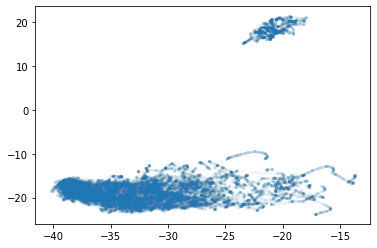

In [179]:
plt.scatter(embed_valid[:,0], embed_valid[:,1], s=5, alpha=0.01)
plt.show()

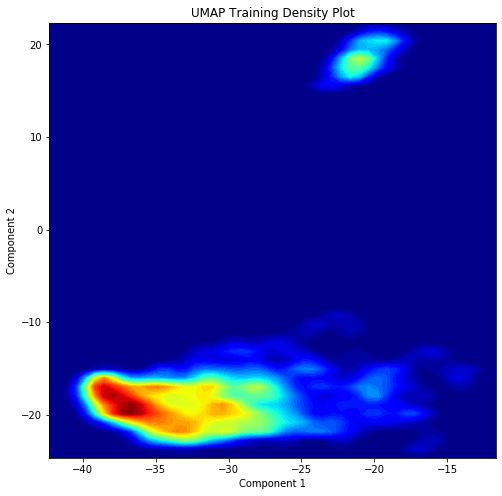

In [178]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.kdeplot(embed_valid[:,0], embed_valid[:,1], 
            shade=True, shade_lowest=True, gridsize=50, 
            levels=50, cmap='jet',cbar=False, ax=ax)
ax.set(xlabel='Component 1', ylabel='Component 2', title="UMAP Training Density Plot")
plt.show()

In [180]:
from sklearn.mixture import GaussianMixture


In [182]:
# Gaussian Mixture Model
gmm = GaussianMixture(n_components=12, random_state=5, max_iter=10000)
gmm_label = gmm.fit_predict(embed_valid)

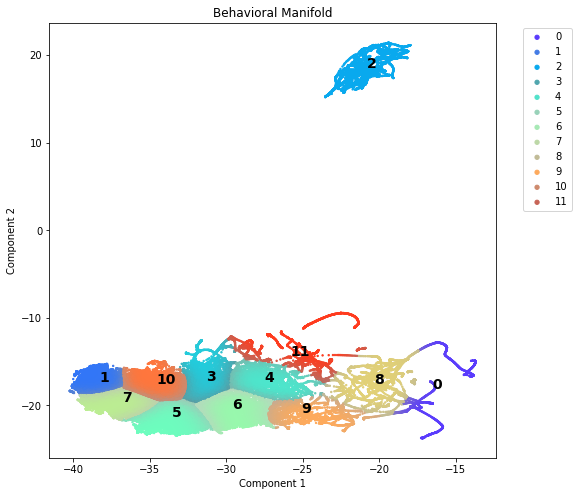

In [185]:
# Compute Stats
num_clusters = np.max(gmm_label) + 1
prob = np.max(gmm.predict_proba(embed_valid), axis=1)

# Choose Color Palette
color_palette = sns.color_palette('rainbow', num_clusters)
cluster_colors = [color_palette[x] for x in gmm_label]
cluster_member_colors = np.array([sns.desaturate(x, p) for x, p in zip(cluster_colors, prob)])

# Create Figures
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(num_clusters):
    idx = (gmm_label==i)
    ax.scatter(embed_valid[idx,0], embed_valid[idx,1], 
                c=cluster_member_colors[idx], 
                alpha=1, s=2, label=i)
    ax.annotate(i, gmm.means_[i], fontsize=14, fontweight='bold')
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=3)
ax.set(xlabel="Component 1", ylabel="Component 2", title="Behavioral Manifold")
plt.show()

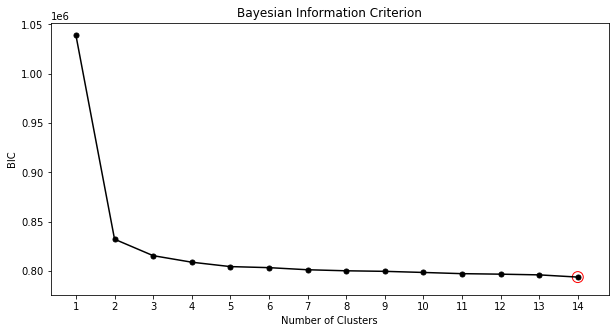

In [186]:
# *** DEFINE ***
max_cluster = 15

# Compute BIC
cluster_list = range(1, max_cluster)
bic_list = []
for n_components in tqdm(cluster_list):
    gmm = GaussianMixture(n_components)
    gmm.fit(embed_valid)
    bic_list.append(gmm.bic(embed_valid))
min_idx = np.argmin(bic_list)

# Plot
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(cluster_list, bic_list, marker="o", c='k', markersize=5)
ax.scatter(min_idx+1, bic_list[min_idx], s=120, edgecolors='r', facecolors='none')
ax.set_xticks(range(1, max_cluster))
ax.ticklabel_format(style="sci", scilimits=(0,5))
ax.set(xlabel='Number of Clusters', ylabel='BIC', title="Bayesian Information Criterion")
plt.show()